In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import natsort
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Concatenate

In [7]:
pip install natsort

Note: you may need to restart the kernel to use updated packages.


In [37]:
## in train_set directory
train_filenames = glob.glob("../input/plant-pathology-2020-fgvc7/images/Train_*.jpg")
test_filenames = glob.glob("../input/plant-pathology-2020-fgvc7/images/Test_*.jpg")

In [9]:
print(len(train_filenames), len(test_filenames))

1821 1821


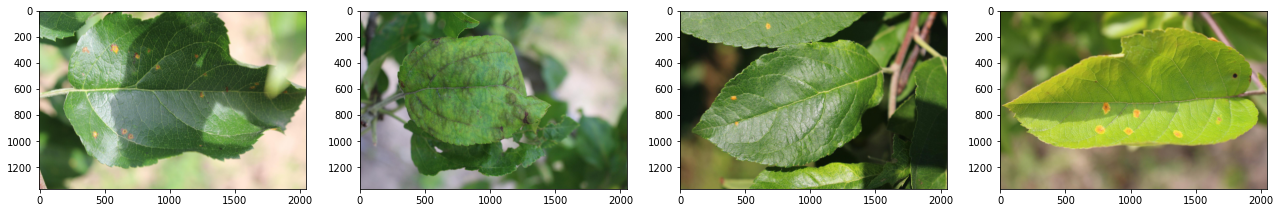

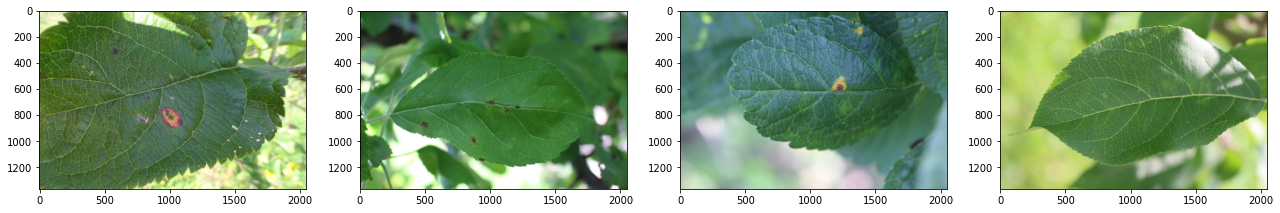

In [10]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)
trianing_images = train_filenames[:4]
for i in range(4):
    image = cv2.cvtColor(cv2.imread(trianing_images[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)
test_images = test_filenames[:4]
for i in range(4):
    image = cv2.cvtColor(cv2.imread(test_images[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)

In [38]:
train_filenames = natsort.natsorted(train_filenames)

In [39]:
train_labels = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")
train_labels

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [40]:
train_labels.loc[1173] = train_labels.loc[379]
train_labels.loc[1] = train_labels.loc[171]

In [41]:
train_labels["image_id"].loc[1173] = "Train_1173"
train_labels["image_id"].loc[1] = "Train_1"

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [42]:
train_labels["path"] = train_filenames

In [43]:
train_labels

,image_id,healthy,multiple_diseases,rust,scab,path
0,Train_0,0,0,0,1,../input/plant-pathology-2020-fgvc7/images/Tra...
1,Train_1,0,0,1,0,../input/plant-pathology-2020-fgvc7/images/Tra...
2,Train_2,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
3,Train_3,0,0,1,0,../input/plant-pathology-2020-fgvc7/images/Tra...
4,Train_4,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,../input/plant-pathology-2020-fgvc7/images/Tra...
1817,Train_1817,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
1818,Train_1818,1,0,0,0,../input/plant-pathology-2020-fgvc7/images/Tra...
1819,Train_1819,0,0,1,0,../input/plant-pathology-2020-fgvc7/images/Tra...


In [44]:
test_labels = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
test_labels

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [45]:
test_filenames = natsort.natsorted(test_filenames)

In [46]:
test_labels["path"] = test_filenames

In [47]:
test_labels

,image_id,path
0,Test_0,../input/plant-pathology-2020-fgvc7/images/Tes...
1,Test_1,../input/plant-pathology-2020-fgvc7/images/Tes...
2,Test_2,../input/plant-pathology-2020-fgvc7/images/Tes...
3,Test_3,../input/plant-pathology-2020-fgvc7/images/Tes...
4,Test_4,../input/plant-pathology-2020-fgvc7/images/Tes...
...,...,...
1816,Test_1816,../input/plant-pathology-2020-fgvc7/images/Tes...
1817,Test_1817,../input/plant-pathology-2020-fgvc7/images/Tes...
1818,Test_1818,../input/plant-pathology-2020-fgvc7/images/Tes...
1819,Test_1819,../input/plant-pathology-2020-fgvc7/images/Tes...


In [48]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [49]:
train_df, valid_df = train_test_split(train_labels, test_size=0.2)


In [50]:
train_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=360, zoom_range=0.3, rescale=1/255.0)
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = "path", 
                                                               y_col = ["healthy", "multiple_diseases", "rust", "scab"],
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, 
                                                               class_mode="raw")

Found 1456 validated image filenames.


In [51]:
valid_generator = ImageDataGenerator(rescale=1/255.0 )
valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = "path",
                                                               y_col = ["healthy", "multiple_diseases", "rust", "scab"],
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, 
                                                               class_mode="raw")

Found 365 validated image filenames.


In [52]:
test_generator = ImageDataGenerator(rescale=1/255.0 )
test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_labels, 
                                                             shuffle=False,
                                                               x_col = "path",
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode = None)

Found 1821 validated image filenames.


In [53]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [ ]:
# xp = tf.keras.applications.Xception(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=input_tensor,
#     input_shape=(299, 299, 3),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

# x = GlobalAveragePooling2D()(xp.output)
# x = Dense(50, activation='relu', name='fc1')(x)
# output = Dense(4, activation="softmax")(x)

# model = Model(inputs=input_tensor, outputs=output)

In [62]:
rn = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
    input_shape=(299, 299, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

x = GlobalAveragePooling2D()(rn.output)
x = Dense(50, activation='relu', name='fc2')(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

In [54]:
# ic = tf.keras.applications.InceptionV3(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=input_tensor,
#     input_shape=(299,299, 3),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

# x = GlobalAveragePooling2D()(ic.output)
# x = Dense(50, activation='relu', name='fc3')(x)
# output = Dense(4, activation="softmax")(x)

# model = Model(inputs=input_tensor, outputs=output)

In [63]:
checkpoint_cb = ModelCheckpoint("my_keras_model_rn.h5", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(patience=12, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, mode="min", verbose=1)

In [64]:
model.compile(optimizer= "sgd", loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC()])
history = model.fit(train_generator_iterator, epochs=64, validation_data=valid_generator_iterator,
                   callbacks=[checkpoint_cb, early_stopping_cb, reducelr_cb])

Epoch 1/64
46/46 [==============================] - 118s 2s/step - loss: 1.0733 - auc_3: 0.7771 - val_loss: 1.0245 - val_auc_3: 0.9005

Epoch 00001: val_loss improved from inf to 1.02452, saving model to my_keras_model_rn.h5
Epoch 2/64
46/46 [==============================] - 103s 2s/step - loss: 0.4160 - auc_3: 0.9689 - val_loss: 0.6172 - val_auc_3: 0.9460

Epoch 00002: val_loss improved from 1.02452 to 0.61717, saving model to my_keras_model_rn.h5
Epoch 3/64
46/46 [==============================] - 103s 2s/step - loss: 0.2496 - auc_3: 0.9889 - val_loss: 0.3125 - val_auc_3: 0.9795

Epoch 00003: val_loss improved from 0.61717 to 0.31252, saving model to my_keras_model_rn.h5
Epoch 4/64
46/46 [==============================] - 103s 2s/step - loss: 0.2515 - auc_3: 0.9877 - val_loss: 0.2834 - val_auc_3: 0.9827

Epoch 00004: val_loss improved from 0.31252 to 0.28342, saving model to my_keras_model_rn.h5
Epoch 5/64
46/46 [==============================] - 103s 2s/step - loss: 0.2013 - auc_3:

In [65]:
model = load_model("my_keras_model_rn.h5")
pred = model.predict(test_generator_iterator)

In [66]:
submission = pd.read_csv("../input/plant-pathology-2020-fgvc7/sample_submission.csv")
submission.loc[:, "healthy":] = pred 
submission.to_csv('submission_rn_1.csv', index=False)